# CSE 6040, Fall 2015 [21]: Linear regression via least squares, Part 1 -- Error analysis

Yay! Time for a new topic: _linear regression by the method of least squares_.

We will do this topic in two parts: one which is generically about the errors that can arise in carrying out a numerical computation, and the other which is specifically about the linear regression problem.

> This lab kicks off the last part of our course, which is a survey of data analysis and mining methods. We will assume you will learn the theory behind these methods in more detail in other classes; our focus will be on algorithmic and implementation concepts.

For today's topic, let's use the following dataset, which is a crimes dataset from 1960: http://cse6040.gatech.edu/fa15/uscrime.csv

This dataset comes from: http://www.statsci.org/data/general/uscrime.html

Other useful references and downloads for today's class:

* Please get the latest version of [`cse6040utils.py`](https://raw.githubusercontent.com/rvuduc/cse6040-ipynbs/master/cse6040utils.py)
* Python's documentation on its `float` type: https://docs.python.org/2/tutorial/floatingpoint.html
* Solvers, including linear systems solvers, in SciPy: http://docs.scipy.org/doc/scipy/reference/linalg.html

Also, much of the discussion of round-off error is taken from an [excellent book](http://epubs.siam.org/doi/book/10.1137/1.9781611971446) on numerical linear algebra.

> You may be able to use the Georgia Tech library's web proxy service to download electronic chapters of this book. Also, this book was written by Rich's former PhD advisor, so a referral thereto is probably not completely objective. `:)`

## Motivation

Let's start by loading a dataset and motivating the problem of modeling it using linear regression.

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
import cse6040utils as cse6040

In [3]:
df = pd.read_csv ('uscrime.csv', skiprows=1)
display (df.head ())

,M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1,U2,Wealth,Ineq,Prob,Time,Crime
0,15.1,1,9.1,5.8,5.6,0.510,95.0,33,30.1,0.108,4.1,3940,26.1,0.084602,26.2011,791
1,14.3,0,11.3,10.3,9.5,0.583,101.2,13,10.2,0.096,3.6,5570,19.4,0.029599,25.2999,1635
2,14.2,1,8.9,4.5,4.4,0.533,96.9,18,21.9,0.094,3.3,3180,25.0,0.083401,24.3006,578
3,13.6,0,12.1,14.9,14.1,0.577,99.4,157,8.0,0.102,3.9,6730,16.7,0.015801,29.9012,1969
4,14.1,0,12.1,10.9,10.1,0.591,98.5,18,3.0,0.091,2.0,5780,17.4,0.041399,21.2998,1234


Each row of this dataset is a US State. The columns are described here: http://www.statsci.org/data/general/uscrime.html

Let's take a quick peek at the dataset.

In [4]:
df.describe ()

,M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1,U2,Wealth,Ineq,Prob,Time,Crime
count,47.000000,47.000000,47.00000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,13.857447,0.340426,10.56383,8.500000,8.023404,0.561191,98.302128,36.617021,10.112766,0.095468,3.397872,5253.829787,19.400000,0.047091,26.597921,905.085106
std,1.256763,0.478975,1.11870,2.971897,2.796132,0.040412,2.946737,38.071188,10.282882,0.018029,0.844545,964.909442,3.989606,0.022737,7.086895,386.762697
min,11.900000,0.000000,8.70000,4.500000,4.100000,0.480000,93.400000,3.000000,0.200000,0.070000,2.000000,2880.000000,12.600000,0.006900,12.199600,342.000000
25%,13.000000,0.000000,9.75000,6.250000,5.850000,0.530500,96.450000,10.000000,2.400000,0.080500,2.750000,4595.000000,16.550000,0.032701,21.600350,658.500000
50%,13.600000,0.000000,10.80000,7.800000,7.300000,0.560000,97.700000,25.000000,7.600000,0.092000,3.400000,5370.000000,17.600000,0.042100,25.800600,831.000000
75%,14.600000,1.000000,11.45000,10.450000,9.700000,0.593000,99.200000,41.500000,13.250000,0.104000,3.850000,5915.000000,22.750000,0.054450,30.450750,1057.500000
max,17.700000,1.000000,12.20000,16.600000,15.700000,0.641000,107.100000,168.000000,42.300000,0.142000,5.800000,6890.000000,27.600000,0.119804,44.000400,1993.000000


In [5]:
import seaborn as sns
%matplotlib inline

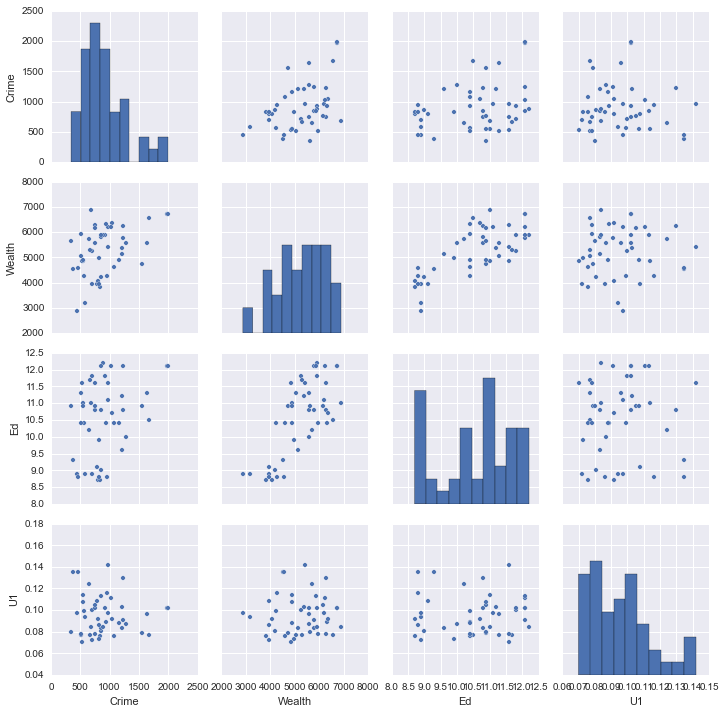

In [6]:
# Look at a few relationships
sns.pairplot (df[['Crime', 'Wealth', 'Ed', 'U1']])

Suppose we wish to build a model of some quantity, called the _response_ variable, given some set of _predictors_. In the US crimes dataset, the response might be the crime rate (`Crime`), which we wish to predict from the predictors of income (`Wealth`), education (`Ed`), and the unemployment rate of young males (`U1`).

In a linear regression model, we posit that the response is a linear function of the predictors. That is, suppose there are $m$ observations in total and consider the $i$-th observation. Let $b_i$ be the response of that observation. Then denote the $n$ predictors for observation $i$ as $\{a_{i,1}, a_{i,2}, \ldots, a_{i,n}\}$. From this starting point, we might then posit a _linear_ model of $b$ having the form,

$b_i = x_0 + a_{i,1} x_1 + a_{i,2} x_2 + \cdots + a_{i,n} x_n$,

where we wish to compute the "best" set of coefficients, $\{x_0, x_1, \ldots, x_n\}$. Note that this model includes a constant offset term, $x_0$. Since we want this model to hold for observations, then we effectively want to solve the system of $m$ equations in $n+1$ unknowns,

$\left(
  \begin{array}{c}
  b_1 \\
  b_2 \\
  \vdots \\
  b_m
  \end{array}
 \right)
$
=
$\left(
   \begin{array}{ccccc}
     1. & a_{1,1} & a_{1,2} & \ldots & a_{1,n} \\
     1. & a_{2,1} & a_{2,2} & \ldots & a_{2,n} \\
        &         & \cdots  &        &         \\
     1. & a_{m,1} & a_{m,2} & \ldots & a_{m,n}
   \end{array}
 \right)
 \left(\begin{array}{c}
   x_0 \\
   x_1 \\
   \vdots \\
   x_n
 \end{array}\right),
$
 
or just $Ax=b$. Typically, there are many more observations than parameters ($m \gg n$), in which case we say this linear system is _overdetermined_.

So how do we compute $x$? Most statistical software and libraries hide the details of computing $x$ from you. However, it's important to understand at least a little bit about what happens under the hood, which is today's topic.

## Aside: Models, Errors, and Algorithms -- Oh my!

The main task of data analysis is to help explain and understand some phenomenon by building a mathematical model from data, and analyzing the model or using it to make predictions. During this process, there are several potential sources of error, including:

* _measurement errors_ in the data, due to limitations in our observational equipment or methodology;
* _modeling error_, due to our mathematical model having simplifying assumptions;
* _truncation error_, due to limitations in our computer algorithms; and
* _rounding error_, due to the fact that we must represent all values on the computer in _finite precision_.

In this course, we will mostly leave measurement and modeling errors as a topics for other courses. Instead, we will focus on truncation and rounding errors, and to a lesser extent, assessing the potential impact of measurement error.

**Exercise.** Are there other kinds of errors not captured in the list above?
 
**Exercise.** Give examples of the kinds of errors that might arise in our motivating problem (i.e., building a linear regression model of crime rates).

_@YOUSE: Enter your discussion / solutions here_

## Floating-point arithmetic

Real values are typically stored in _IEEE floating-point format_. If you have programmed in other languages, you may have seen scalar data types for _single-precision_ and _double-precision_ formats (e.g., `float` and `double` in C/C++/Java). A "floating-point" encoding is basically a normalized scientific notation consisting of a _base_, a _sign_, a fractional _mantissa_, and an integer _exponent_. Let's look at an example to see how this might work.

Consider the value 0.125. In a normalized scientific notation, we would write this number as $+1.25 \times 10^{-1}$, where the base is 10, the mantissa is 1.25, and the exponent is -1. Conceptually, if we always used base 10 for all our floating-point values, then our floating-point encoding of this value would, conceptually, be a tuple $(+, 1.25, -1)$. 

However, we cannot store an infinite number of digits for the mantissa and exponent values. Thus, we would normally _also_ limit the number of digits that may appear in either. We might use, say, 6 digits for the mantissa and 2 digits (ignoring the sign) for the exponent, i.e., a tuple of the form $(\pm, m.mmmmm, \pm xx)$.

**Exercise.** What is the largest value we could represent in this format? What is the smallest value? What is the smallest _positive_ value we could represent? How would we encode these values?

_@YOUSE: Enter your solutions here_

**Exercise.** Encode the following values as tuples:

1. $1.0$
2. $-10^{-6}$
3. $1.0 - 10^{-6}$
4. $1.0 + 10^{-6}$

_@YOUSE: Enter your solutions here_

1. (+, 1.00000, +00)
2. (-, 1.00000, -06)
3. (+, 9.99999, -01)
4. (+, 1.00000, +00)
       0.000001 == 10^(-6)



### A small surprise? The consequences of finite-precision

Let $a=1.0$ and $b=10^{-6}$. Now consider two programs.

_Program 1_:

    s = a - b
    t = s + b
    
_Program 2_:

    s = a + b
    t = s - b
    
If the _precision_, or number of digits in the encoding, were infinite, then both programs would produce `t == a == 1.0`.

**Exercise.** Suppose we instead use a _finite-precision_ floating-point encoding, using base 10 digits with 6 digits of precision for the mantissa and 2 digits for the exponent, plus separate sign "digits" for each. What is the final value of `t` in each of these two programs?

_@YOUSE: Enter your solutions here_

The preceding examples assume the digits are represented in base 10. However, computers encode all values using _bits_, which are _base 2_ digits. All the same ideas as above apply, but on base 2 values rather than base 10 values.

One consequence of this difference is that certain finite-precision decimal fractions _cannot_ be represented exactly!

> Can you see why? Consider the decimal value 0.1 represented in a binary format.

In addition, the IEEE floating-point standard defines the encoding a little differently than we've used it. First, if the value is not 0, then the mantissa _always_ has an implicit "1" as the leading digit; therefore, it needn't be stored explicitly, thereby saving a bit and effectively increasing the precision a little. Secondly, the range of the exponent is not symmetric. In our hypothetical base-10 "6 + 2" encoding, we assumed the exponent would range from -99 to 99, which is a symmetric interval; in IEEE floating-point, there will be a slight asymmetry in this range. Part of the reason is that the IEEE floating-point encoding can also represent several kinds of special values, such as infinities and an odd bird called "not-a-number" or `NaN`. This latter value, which you may have seen if you have used any standard statistical packages, can be used to encode certain kinds of floating-point exceptions that result when, for instance, you try to divide by zero.

In IEEE floating-point, there are two main encodings, known as _single-precision_ (`float` in C/C++/Java) and _double-precision_ (`double` in C/C++/Java). In brief, these differ as follows:

* Single-precision: 32 bits total, with 24 bits for the mantissa and an exponent range of [-126, 127].

* Double-precision: 64 bits total, with 53 bits for the mantissa and an exponent range of [-1022, 1023].

**Exercise.** What is the smallest positive value that can be represented in IEEE single-precision? What about in double-precision?

_@YOUSE: Enter your solutions here_

**Exercise.** Consider the smallest possible value greater than 1.0 that can be represented in floating-point. Let's call this value, $1.0 + \epsilon$.

Determine $\epsilon_s$ and $\epsilon_d$, the corresponding values of $\epsilon$ in single-precision and double-precision, respectively.

_@YOUSE: Enter your solutions here_

Another important consequence of the binary format is that when you print things in base ten, what you see may not be what you get! For instance, try running the code below.

In [8]:
from decimal import Decimal

x = 1.0 + 2.0**(-52)

print x
print Decimal (x) # What does this do?

1.0
1.0000000000000002220446049250313080847263336181640625


> Aside: If you ever need true decimal storage with no loss of precision, turn to the `Decimal` package. Just be warned it will come at a price:

In [9]:
a_native = 1.0
b_native = 2.0

a_decimal = Decimal ('1.0')
b_decimal = Decimal ('2.0')

%timeit a_native + b_native
%timeit a_decimal + b_decimal

The slowest run took 52.87 times longer than the fastest. This could mean that an intermediate result is being cached 
10000000 loops, best of 3: 108 ns per loop
The slowest run took 106.00 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 19.7 µs per loop


For today's lesson, it will be helpful to occasionally peek at floating-point values "in the raw." For this purpose, we've provided you with a handy routine called `float_to_bin(x)`, which given a floating-point value `x` will return its IEEE representation as a binary string. (It is defined in the `cse6040utils` module.)

The following code uses `float_to_bin()` to define another function that dumps a floating-point number's complete `Decimal` form along with its binary form.

In [10]:
def print_float_bin (x, prefix=""):
    print ("%s: %s\n%s  %s" % (prefix,
                                Decimal (x),
                                ' ' * len (prefix),
                                cse6040.float_to_bin (x)))    

a = -1.0
b = 2.**(-52)  # Recall: \epsilon_d
c = b / 2.

print_float_bin (a, prefix="a")
print_float_bin (b, prefix="b")
print_float_bin (c, prefix="c")

a: -1
   [-1.0000000000000000000000000000000000000000000000000000]_{2}e+0
b: 2.220446049250313080847263336181640625E-16
   [1.0000000000000000000000000000000000000000000000000000]_{2}e-52
c: 1.1102230246251565404236316680908203125E-16
   [1.0000000000000000000000000000000000000000000000000000]_{2}e-53


**Exercise.** Recall the two program fragments from above:

_Program 1_:

    s = a - b
    t = s + b
    
_Program 2_:

    s = a + b
    t = s - b

Let $a=1.0$ and $b=\epsilon_d / 2 \approx 1.11 \times 10^{-16}$. Write some Python code to evaluate these two programs and compare their outputs. (To look closely at their outputs, use the `print_float_bin()` function from above.)

In [13]:
a = 1.0
b = 2.**(-53) # What value goes here?

s1 =  a - b
t1 = s1 + b

s2 =  a + b
t2 = s2 - b

print_float_bin (s1, prefix="s1")
print_float_bin (t1, prefix="t1")
print ("\n")
print_float_bin (s2, prefix="s2")
print_float_bin (t2, prefix="t2")

print "\n", t1, t2
print ("\n(t1 == t2) == %s" % (t1 == t2))

s1: 0.99999999999999988897769753748434595763683319091796875
    [1.1111111111111111111111111111111111111111111111111111]_{2}e-1
t1: 1
    [1.0000000000000000000000000000000000000000000000000000]_{2}e+0


s2: 1
    [1.0000000000000000000000000000000000000000000000000000]_{2}e+0
t2: 0.99999999999999988897769753748434595763683319091796875
    [1.1111111111111111111111111111111111111111111111111111]_{2}e-1

1.0 1.0

(t1 == t2) == False


By the way, in Numpy you can determine machine epsilon in a more portable way:

In [14]:
EPS_S = np.finfo (np.float32).eps
EPS_D = np.finfo (float).eps

print_float_bin (float (EPS_S), prefix="eps_s")
print_float_bin (float (EPS_D), prefix="eps_d")

eps_s: 1.1920928955078125E-7
       [1.0000000000000000000000000000000000000000000000000000]_{2}e-23
eps_d: 2.220446049250313080847263336181640625E-16
       [1.0000000000000000000000000000000000000000000000000000]_{2}e-52


## Perturbation theory and condition numbers

Given the various sources of error, how do we know whether a given algorithm is "good" for computing the solution to a given problem? An important tool in the area of _numerical analysis_ is _perturbation theory_.

To see perturbation theory in action, suppose we wish to determine by how much a "small" measurement error, $\Delta x$, affects the output of some function, $f(x)$. Barring any other information and assuming $f(x)$ is continuous and differentiable, we could try to estimate the error of evaluating $f(x + \Delta x)$ compared to $f(x)$ by the following linear approximation, which comes from a Taylor series expansion:

$$f(x + \Delta x) \approx f(x) + \Delta x \cdot f'(x),$$

where $f'(x)$ is the first derivative of $f(x)$ at the point $x$.

**Absolute condition numbers.** From this relation, we can compute an upper-bound on the absolute value of the error:

$$\left|f(x + \Delta x) - f(x)\right| \approx \left|\Delta x\right| \cdot \left|f'(x)\right|.$$

This calculation says that the error depends not only on the measurement error, $\Delta x$, _but also_ the nature of the function itself at $x$ through the factor, $\left|f'(x)\right|$. Indeed, we will give this factor a special name of _absolute condition number_ of evaluating $f$ at $x$. For any given computational problem, we will try to find condition numbers to help us quantify the "hardness" of the problem.

That is, for the problem of evaluating $f(x)$, the preceding analysis says that if this factor is not too large, then small measurement errors will lead to only small errors in the output. In this case, we say the problem is _well-conditioned_. If instead this factor is very large, then even very small errors will lead to large errors in the output. In this case, we say the problem is _ill-conditioned_.

Put differently, the problem of evaluating $f(x)$ when the condition number is large is inherently _more difficult_ than doing so when the condition number is small.

**Relative condition numbers.** The error considered above is the absolute error, in contrast to the _relative error_,

$$\left|f(x + \Delta x) - f(x)\right| / \left|f(x)\right|.$$

For this case and problem of evaluating $f(x)$, let's rewrite this slightly as,

$$\frac{\left|f(x + \Delta x) - f(x)\right|}
      {\left|f(x)\right|}
\approx
 \frac{|\Delta x|}
      {|x|}
   \cdot
\underbrace{
 \frac{\left|f'(x)\right| \cdot |x|}
      {\left|f(x)\right|}
}_{\equiv\ \kappa_r(x)}
,$$

where $\kappa_r(x)$ is the _relative condition number_ of evaluating $f(x)$ at $x$.
      
Observe that this relation expresses the relative change in the output as a function of some relative change in the input ($|\Delta x| / |x|$).

**Backward stability.** Let's say someone devises an algorithm to compute $f(x)$. For a given value $x$, let's suppose this algorithm produces the value $\mathrm{alg}(x)$. One important question might be, is that output "good" or "bad?"

One property to measure "goodness" will be _backward stability_. In particular, we will say that $\mathrm{alg}(x)$ is a _backward stable algorithm_ to compute $f(x)$ if, for all $x$, there exists a "small" $\Delta x$ such that

$$\mathrm{alg}(x) = f(x + \Delta x).$$

That should look familiar! It means we can estimate the (absolute) backward error using our perturbation analysis from before, i.e.,

$$\left|\mathrm{alg}(x) - f(x)\right| \approx \left|f'(x)\right| \cdot \left|\Delta x\right|.$$

**Round-off errors.** We already know that numerical values can only be represented finitely, which introduces round-off error. Thus, at the very least we should hope that a scheme to compute $f(x)$ is as insensitive to round-off errors as possible.

To quantify sensitivity, the standard technique is to assume that every scalar floating-point operation incurs some bounded error. Let $a \odot b$ be the exact result of some mathematical operation on $a$ and $b$, and let $\mathrm{fl}(a \odot b)$ be the computed value, after rounding in finite-precision. We will model the difference by,

$$\mathrm{fl}(a \odot b) \equiv (a \odot b) (1 + \delta),$$

where $|\delta| \leq \epsilon$, machine epsilon.

## (Left off here)

In class, we left off at this point. Indeed, there were some errors in the text that had appeared below, so they have been removed. We will pick up here (with the correct text!) in the next class.